In [1]:
import polars as pl
import numpy as np
from utils import Donation
from scipy.optimize import minimize
from scipy.special import gammaln, comb, hyp2f1
from scipy.special import beta as beta_fn
from scipy.stats import beta as beta_dist
from scipy.integrate import quad

import altair as alt
import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import display_markdown

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

**Source**: 
- [Customer-Base Analysis in a Discrete-Time Noncontractual Setting](http://www.brucehardie.com/papers/020/)
- [Implementing the BG/BB Model for Customer-Base Analysis in Excel](http://www.brucehardie.com/notes/010/)
- [Implementing the $S_{BB}-G/B$ Model in MATLAB](http://www.brucehardie.com/notes/023/)

In [2]:
data = Donation()
rfm_summary_calib = data.p1x_data()
rfm_array_calib = rfm_summary_calib.collect().to_numpy()
rfm_summary_valid = data.p2x_data()
p1x, t_x, _, num_donors = [*rfm_array_calib.T]

n = 6
n * (n + 1)/2 + 1 # Possible recency/frequency patterns in calibration period
years = data.years

In [3]:
def rfcalib_cross_tab(df, values, title, subtitle=None, color_range=[0,1]):
    tx_year_map = {tx: int(year) for tx, year in enumerate(years)}
    
    return (
        df
        .with_columns(pl.col("t_x").replace(tx_year_map).alias("Year"))
        .sort('Year')
        .pivot(on='Year', index='P1X', values=values)
        .sort('P1X')
        .style.tab_header(title=title, subtitle=subtitle)
        .tab_stub(rowname_col="P1X")
        .tab_stubhead(label='P1X')
        .fmt_number(decimals=2)   
        .tab_spanner(
            label="Year of last transaction",
            columns=years[:7]
        ).data_color(
            domain=color_range,
            palette=["white", "rebeccapurple"],
            na_color="white",
        ).sub_missing(
            columns=pl.col('*'),
            missing_text=""
        )            
    )

### Parameter Estimation

In [4]:
def bgbb_est(rfm_data, guess={'alpha': 1, 'beta': 0.5, 'gamma': 0.5, 'delta': 2.5}):
    p1x, t_x, n, num_donors = [*rfm_data.T]

    def log_likelihood(param):
        alpha, beta, gamma, delta = param
        B_alpha_beta = beta_fn(alpha, beta)
        B_gamma_delta = beta_fn(gamma, delta)
        
        A1 = beta_fn(alpha+p1x,beta+n-p1x)/B_alpha_beta * \
                 beta_fn(gamma,delta+n)/B_gamma_delta
        i = np.arange(6).reshape(-1,1)
        A2 = beta_fn(alpha+p1x, beta+t_x-p1x+i)/B_alpha_beta* \
                  beta_fn(gamma+1, delta+t_x+i)/B_gamma_delta        
        A2 = np.where(i <=  (n - t_x - 1), A2, 0)

        return -np.sum(num_donors * np.log(A1 + np.sum(A2, axis=0)))
    
    bnds = [[0, np.inf] for _ in range(4)]
    return minimize(log_likelihood, x0=list(guess.values()), bounds=bnds)

# Sample parameters
# alpha = 1.20352083040498
# beta = 0.749714243061896
# gamma = 0.656712169147878
# delta = 2.78340801635898

res = bgbb_est(rfm_array_calib)
alpha, beta, gamma, delta = res.x
ll = res.fun

display_markdown(f'''$\\alpha$ = {alpha:0.4f}

$\\beta$ = {beta:0.4f}

$\\gamma$ = {gamma:0.4f}

$\\delta$ = {delta:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

$\alpha$ = 1.2035

$\beta$ = 0.7497

$\gamma$ = 0.6568

$\delta$ = 2.7840

Log-Likelihood = -33225.5813

### Likelihood Function

Likelihood function for a randomly chosen customer with purchase history ($x, t_{x}, n$)

In [5]:
B_alpha_beta = beta_fn(alpha, beta)
B_gamma_delta = beta_fn(gamma, delta)

A1 = beta_fn(alpha+p1x, beta+n-p1x)/B_alpha_beta * beta_fn(gamma, delta+n)/B_gamma_delta
i = np.arange(6).reshape(-1,1)
A1a = beta_fn(alpha+p1x, beta+t_x-p1x+i)/B_alpha_beta * beta_fn(gamma+1, delta+t_x+i)/B_gamma_delta  
A1a = np.where(i <= (n - t_x - 1), A1a, 0)
L = A1 + np.sum(A1a, axis=0)

L_df = rfm_summary_calib.collect().hstack([pl.Series('Likelihood', L)])

### In-Sample Model Fit Plot

In [6]:
x = np.arange(n+1)
A1 = comb(n,x)*beta_fn(alpha+x, beta+n-x)/B_alpha_beta*beta_fn(gamma, delta+n)/B_gamma_delta 
i = np.arange(n).reshape(-1,1)
A2 = comb(i,x)*beta_fn(alpha+x, beta+i-x)/B_alpha_beta * beta_fn(gamma+1, delta+i)/B_gamma_delta
P_X_n = A1 + np.sum(A2,axis=0)

model_repeat_calib = pl.DataFrame({'Model': P_X_n * np.sum(rfm_array_calib[:,3])})

actual_model_repeat_calib = (
    rfm_summary_calib
    .group_by('P1X')
    .agg((pl.col('Count').sum()).alias('Actual'))
    .sort('P1X')
    .collect()
    .hstack(model_repeat_calib)
    .unpivot(on=['Actual', 'Model'], index='P1X', value_name='No of people', variable_name='Actual Vs Estimated')
)

(
    alt.Chart(actual_model_repeat_calib).mark_bar()
    .encode(x=alt.X('P1X:O', title='No. of repeat transactions', axis=alt.Axis(labelAngle=0)), 
         y=alt.Y('No of people:Q', title='No. of people'), 
         color='Actual Vs Estimated:N', 
         xOffset='Actual Vs Estimated')
    .properties(
        width=650,
        height=250,
        title='Predicted vs. Actual Frequency of Repeat Transactions (Calibration Period) in 1996 to 2001'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)   
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Calibration Period Model Fit Plot

In [7]:
n_star = 5
x_star = np.arange(n_star+1)

A1 = comb(n_star,x_star)*beta_fn(alpha+x_star, beta+n_star-x_star)/B_alpha_beta * beta_fn(gamma, delta+n+n_star)/B_gamma_delta
A1 += np.where(x_star == 0, 1 - beta_fn(gamma, delta+n)/B_gamma_delta, 0)
i = np.arange(n_star).reshape(-1,1)
A2 = comb(i,x_star)*beta_fn(alpha+x_star, beta+i-x_star)/B_alpha_beta * beta_fn(gamma+1, delta+n+i)/B_gamma_delta
P_X_n_star = A1 + np.sum(A2, axis=0)

valid_repeat_count = rfm_summary_valid.collect().to_numpy()[:,2]
model_repeat_valid = pl.DataFrame({'Model': P_X_n_star * np.sum(valid_repeat_count)})

actual_model_repeat_valid = (
    rfm_summary_valid
    .group_by('P2X')
    .agg((pl.col('Count').sum()).alias('Actual'))
    .sort('P2X')
    .collect()
    .hstack(model_repeat_valid)
    .unpivot(on=['Actual', 'Model'], index='P2X', value_name='No of people', variable_name='Actual Vs Estimated')
)

(
    alt.Chart(actual_model_repeat_valid).mark_bar()
    .encode(x=alt.X('P2X:O', title='No. of repeat transactions', axis=alt.Axis(labelAngle=0)), 
         y=alt.Y('No of people:Q', title='No. of people'), 
         color='Actual Vs Estimated:N', 
         xOffset='Actual Vs Estimated')
    .properties(
        width=650,
        height=250,
        title='Predicted vs. Actual Frequency of Repeat Transactions (Validation Period) in 2002-2006'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)   
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Tracking Plots

In [8]:
act_yearly_repeat = data.data.select(pl.col('*').exclude('ID', '1995')).sum().collect().to_numpy()
act_cum_repeat = act_yearly_repeat.cumsum()

A1 = alpha / (alpha + beta)
A2 = 1/(gamma-1)
n_trans = np.arange(1, len(years))
A3 = np.exp(gammaln(delta+n_trans+1)+gammaln(gamma+delta)-gammaln(delta)-gammaln(gamma+delta+n_trans))
E_X_n = A1 * (delta*A2-A2*A3)

est_cum_repeat = np.sum(rfm_array_calib[:,3]) * E_X_n
est_yearly_repeat = np.diff(est_cum_repeat, prepend=0)

yearly_repeat = pl.DataFrame({'Year': years[1:], 'Actual': act_yearly_repeat.flatten(), 'Model': est_yearly_repeat.flatten()})
yearly_repeat = yearly_repeat.unpivot(on=['Actual', 'Model'], index='Year', variable_name='Actual Vs Model', value_name='Repeat Trans')
cum_repeat = pl.DataFrame({'Year': years[1:], 'Actual': act_cum_repeat.flatten(), 'Model': est_cum_repeat.flatten()})
cum_repeat = cum_repeat.unpivot(on=['Actual', 'Model'], index='Year', variable_name='Actual Vs Model', value_name='Repeat Trans')

(
    alt.Chart(yearly_repeat).mark_line().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='No. of repeat transactions'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Annual Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [9]:
(
    alt.Chart(yearly_repeat).mark_bar().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='No. of repeat transactions'),
        color='Actual Vs Model',
        xOffset='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Annual Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [10]:
(
    alt.Chart(cum_repeat).mark_line().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='Cumulative no. of repeat transactions'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Cumulative Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [11]:
(
    alt.Chart(cum_repeat).mark_bar().encode(
        x=alt.X('Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Repeat Trans', title='Cumulative no. of repeat transactions'),
        color='Actual Vs Model',
        xOffset='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Cumulative Repeat Transactions'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Conditional Expectations

In [12]:
n_star = 5

A2 = beta_fn(alpha+p1x+1, beta+n-p1x)/B_alpha_beta
A3 = delta/(gamma-1)*np.exp(gammaln(gamma+delta)-gammaln(delta+1))*(np.exp(gammaln(1+delta+n)-\
     gammaln(gamma+delta+n))-np.exp(gammaln(1+delta+n+n_star)-gammaln(gamma+delta+n+n_star)))

ce = A2 * A3 / L

exp_total = ce * num_donors

ce_df = (
    data.rfm_data()
    .group_by('P1X', 't_x', 'np1x')
    .agg(pl.col('P2X').sum().alias('Actual Total - Valid'))
    .sort(['t_x', 'P1X'], descending=True)
    .collect()
    .hstack([pl.Series('Exp Total', exp_total)])
    .hstack([pl.Series('Conditional Expectation', ce)])
)

# Actual total 2002-2006 donations by p1x / tx
actual_ce_mat = ce_df.sort('t_x').pivot(index='P1X', on='t_x', values='Actual Total - Valid').sort('P1X').fill_null(0).to_numpy()
p1x_frequency = actual_ce_mat[:,0]
actual_ce_mat = actual_ce_mat[:,1:]

# Expected total 2002-2006 donations by p1x / tx
est_ce_mat = ce_df.sort('t_x').pivot(index='P1X', on='t_x', values='Exp Total').sort('P1X').fill_null(0).to_numpy()[:,1:]

# Number of Donors
num_donors_mat = rfm_summary_calib.collect().sort('t_x').pivot(index='P1X', on='t_x', values='Count').sort('P1X').fill_null(0).to_numpy()[:,1:]

# CE by Frequency
actual_ce_freq = np.sum(actual_ce_mat, axis=1) / np.sum(num_donors_mat, axis=1)
est_ce_freq = np.sum(est_ce_mat, axis=1) / np.sum(num_donors_mat, axis=1)
ce_freq = pl.DataFrame({'x': p1x_frequency, 'Actual': actual_ce_freq, 'Model': est_ce_freq})
ce_freq = ce_freq.unpivot(index='x', on=['Actual', 'Model'], variable_name='Actual Vs Model', value_name='CE by Freq')

# CE by Recency
actual_ce_rec = np.sum(actual_ce_mat, axis=0) / np.sum(num_donors_mat, axis=0)
est_ce_rec = np.sum(est_ce_mat, axis=0) / np.sum(num_donors_mat, axis=0)
ce_rec = pl.DataFrame({'t_x': years[:len(p1x_frequency)], 'Actual': actual_ce_rec, 'Model': est_ce_rec}).with_columns(pl.col('t_x').cast(pl.Int16))
ce_rec = ce_rec.unpivot(index='t_x', on=['Actual', 'Model'], variable_name='Actual Vs Model', value_name='CE by Rec')

In [13]:
(
    alt.Chart(ce_freq).mark_line().encode(
        x=alt.X('x', title='No. of repeat transactions (1996-2001)', axis=alt.Axis(labelAngle=0, values=np.arange(7))),
        y=alt.Y('CE by Freq', title='No. of repeat transactions (2002–2006)'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Conditional Expectations of Repeat Transactions in 2002–2006 as a Function of Frequency'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [14]:
(
    alt.Chart(ce_rec).mark_line().encode(
        x=alt.X('t_x', title='Year of last transaction', axis=alt.Axis(labelAngle=0, values=np.arange(1995, 2002, 1), format='.0f')),
        y=alt.Y('CE by Rec', title='No. of repeat transactions (2002–2006)'),
        strokeDash='Actual Vs Model'
    ).properties(
            width=650,
            height=250,
            title='Predicted vs. Actual Conditional Expectations of Repeat Transactions in 2002–2006 as a Function of Recency'
    ).configure_view(stroke=None).configure_axisY(grid=False).configure_axisX(grid=False)  
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [15]:
rfcalib_cross_tab(ce_df, 
                  values='Conditional Expectation',
                  title='Expected Number of Repeat Transactions in 2002–2006',
                  subtitle='as a Function of Recency and Frequency',
                  color_range=[0,4])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.072867 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null     ┆ 0.085696 ┆ 0.314228 ┆ 0.593827 ┆ 0.83936  ┆ 1.02165  ┆ 1.147848 │
│ 2   ┆ null     ┆ null     ┆ 0.119117 ┆ 0.536089 ┆ 1.057563 ┆ 1.442999 ┆ 1.668778 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.223582 ┆ 1.034528 ┆ 1.804653 ┆ 2.189709 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.583154 ┆ 2.029963 ┆ 2.710639 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 1.81286  ┆ 3.231569 │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 3.7525   │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x1191b8050>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x1191b0550>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='Expected Number of Repeat Transactions in 2002–2006', subtitle='as a Function of Recency and Frequency', preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#d9cce6')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#b299cc')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#8c66b2')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rown

### P(Alive) as a Function of Recency and Frequency

In [16]:
A1 = np.exp(gammaln(alpha+p1x)+gammaln(beta+n-p1x)-gammaln(alpha+beta+n))/B_alpha_beta * \
                        np.exp(gammaln(gamma)+gammaln(delta+n+1)-gammaln(gamma+delta+n+1))/B_gamma_delta
P_alive = A1 * L**-1

rfcalib_cross_tab(rfm_summary_calib.collect().hstack(pl.DataFrame({'P(Alive)': P_alive})), 
                  values='P(Alive)',
                  title='P(Alive in 2002) as a Function of Recency and Frequency',
                  color_range=[0,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.108144 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null     ┆ 0.069464 ┆ 0.254709 ┆ 0.481348 ┆ 0.680373 ┆ 0.828135 ┆ 0.930429 │
│ 2   ┆ null     ┆ null     ┆ 0.066414 ┆ 0.298897 ┆ 0.589645 ┆ 0.804546 ┆ 0.930429 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.095002 ┆ 0.439581 ┆ 0.766815 ┆ 0.930429 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.200168 ┆ 0.696787 ┆ 0.930429 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.521956 ┆ 0.930429 │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.930429 │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x1191acfc0>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x1191ad220>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='P(Alive in 2002) as a Function of Recency and Frequency', subtitle=None, preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, styles=[CellS

### Posterior Mean of P as a Function of Recency and Frequency

In [17]:
l = 1
m = 0
alphal = alpha + l
gammam = gamma + m

B_alphal_beta = beta_fn(alphal, beta)
B_gammam_delta = beta_fn(gammam, delta)

A1 = beta_fn(alphal+p1x, beta+n-p1x)/B_alphal_beta * beta_fn(gammam, delta+n)/B_gammam_delta
i = np.arange(6).reshape(-1,1)
A2 = beta_fn(alphal+p1x, beta+t_x-p1x+i)/B_alphal_beta * beta_fn(gammam+1, delta+t_x+i)/B_gammam_delta  
A2 = np.where(i <= (n - t_x - 1), A2, 0)
L_lm = A1 + np.sum(A2, axis=0) 

E_P_Theta = (B_alphal_beta/B_alpha_beta) * (B_gammam_delta/B_gamma_delta) * (L_lm/L)

rfcalib_cross_tab(rfm_summary_calib.collect().hstack(pl.DataFrame({'E_P_Theta': E_P_Theta})), 
                  values='E_P_Theta',
                  title='Posterior Mean of P as a Function of Recency and Frequency',
                  color_range=[0.2,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995     ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.487723 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null     ┆ 0.663354 ┆ 0.442589 ┆ 0.340437 ┆ 0.297261 ┆ 0.281435 ┆ 0.277055 │
│ 2   ┆ null     ┆ null     ┆ 0.751243 ┆ 0.544319 ┆ 0.44468  ┆ 0.410628 ┆ 0.402791 │
│ 3   ┆ null     ┆ null     ┆ null     ┆ 0.797491 ┆ 0.611963 ┆ 0.541894 ┆ 0.528527 │
│ 4   ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.817711 ┆ 0.677892 ┆ 0.654263 │
│ 5   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.829248 ┆ 0.78     │
│ 6   ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.905736 │
└─────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x11611e140>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x1191c0a70>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='Posterior Mean of P as a Function of Recency and Frequency', subtitle=None, preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, styles=[Ce

Prior and Selected Posterior Distributions of (a) $P$ and (b) $\Theta$

A customer’s latent transaction and dropout probabilities.

In [18]:
def marginal_posterior(x, tx, p_theta, theta=False):
    i = np.arange(n).reshape(-1,1)
    if not theta:
        B1 = p_theta**(alpha+x-1)*(1-p_theta)**(beta+n-x-1)/B_alpha_beta * beta_fn(gamma, delta + n)/B_gamma_delta
        B2 = p_theta**(alpha+x-1)*(1-p_theta)**(beta+tx-x+i-1)/B_alpha_beta * beta_fn(gamma+1, delta + tx + i)/B_gamma_delta
    else:
        B1 = beta_fn(alpha+x,beta+n-x)/B_alpha_beta * (p_theta**(gamma-1)*(1-p_theta)**(delta+n-1))/B_gamma_delta
        B2 = beta_fn(alpha+x, beta+tx-x+i)/B_alpha_beta * (p_theta**gamma*(1-p_theta)**(delta+tx+i-1))/B_gamma_delta
    B2 = np.where(i <= (n - tx - 1), B2, 0)
    L = L_df.filter((pl.col('P1X') == x) & (pl.col('t_x') == tx)).select('Likelihood').item()
    return (B1 + np.sum(B2, axis=0)) / L 

def compute_mean(x, tx, theta=False):
    # Function for the marginal posterior distribution
    def posterior_func(p_theta):
        return p_theta * marginal_posterior(x, tx, p_theta, theta=theta)
    
    # Integrate over the range [0, 1] for p or theta
    mean, _ = quad(posterior_func, 0, 1)
    return mean

Text(0.7, 3, '$E(P) = 0.62$')

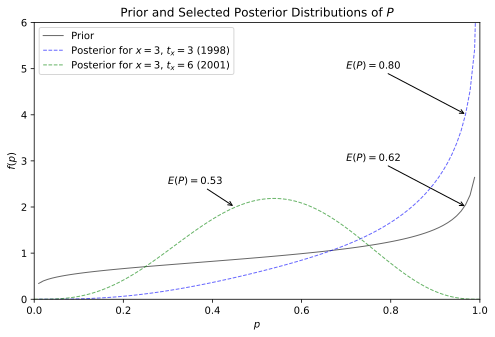

In [19]:
def annotate(ax, xy, xytext, str):
    return ax.annotate(str,
            xy=xy, xycoords='data',
            xytext=xytext, textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
        
fig, ax = plt.subplots(figsize=(8, 5))
p = np.linspace(beta_dist.ppf(0, alpha, beta),
                beta_dist.ppf(0.99, alpha, beta), 100)
ax.plot(p[1:-1], beta_dist.pdf(p[1:-1], alpha, beta), 'k', lw=1, alpha=0.6, label='Prior')
ax.plot(p[1:], marginal_posterior(3,3, p[1:]), 'b--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 3$ (1998)')
ax.plot(p, marginal_posterior(3,6, p), 'g--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 6$ (2001)')
ax.set_xlabel('$p$')
ax.set_ylabel('$f(p)$')
ax.set_title('Prior and Selected Posterior Distributions of $P$')
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,6)
annotate(ax, (0.45, 2), (0.3, 2.5), f"$E(P) = {compute_mean(3,6):.2f}$")
annotate(ax, (0.97, 4), (0.7, 5), f"$E(P) = {compute_mean(3,3):.2f}$")
annotate(ax, (0.97, 2), (0.7, 3), f"$E(P) = {beta_dist.stats(alpha, beta, moments='m'):.2f}$")

Text(0.1, 6.7, '$E(\\Theta) = 0.19$')

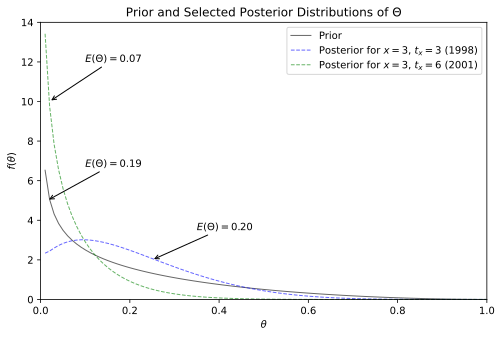

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
p = np.linspace(beta_dist.ppf(0, alpha, beta),
                beta_dist.ppf(0.99, alpha, beta), 100)
ax.plot(p, beta_dist.pdf(p, gamma, delta), 'k', lw=1, alpha=0.6, label='Prior')
ax.plot(p[1:], marginal_posterior(3,3, p[1:],theta=True), 'b--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 3$ (1998)')
ax.plot(p[1:], marginal_posterior(3,6, p[1:],theta=True), 'g--', lw=1, alpha=0.6, label='Posterior for $x = 3$, $t_{x} = 6$ (2001)')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$f(\\theta)$')
ax.set_title('Prior and Selected Posterior Distributions of $\\Theta$')
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,14)
annotate(ax, (0.02, 10), (0.1, 12), f"$E(\\Theta) = {compute_mean(3,6,theta=True):.2f}$")
annotate(ax, (0.25, 2), (0.35, 3.5), f"$E(\\Theta) = {compute_mean(3,3,theta=True):.2f}$")
annotate(ax, (0.015, 5), (0.1, 6.7), f"$E(\\Theta) = {beta_dist.stats(gamma, delta, moments='m'):.2f}$")

### Conditional Penetration

Probability that a customer with purchase history ($x, t_{x}, n$) makes $x^{*}$ transactions in the interval $(n,n + n^{*}]$.

The probability that a customer is active in the 2002–2006 period ($n^{*} = 5$) is computed as $1-P(X(n,n+n^{*})=0 \mid x,t_{x}, n)$, where $x^{*}=0$, conditional on each of the 22 ($x,t_{x}$) patterns associated with $n = 6$.

In [21]:
n_star = 5
x_star = 0

A1 = beta_fn(alpha+p1x, beta+n-p1x)/B_alpha_beta * beta_fn(gamma, delta+n)/B_gamma_delta
B1 = np.where(x_star == 0, 1-(A1/L), 0)
A2 = comb(n_star, x_star) * beta_fn(alpha+p1x+x_star,beta+n-p1x+n_star-x_star)/B_alpha_beta * \
    beta_fn(gamma, delta+n+n_star)/beta_fn(gamma, delta)
i = np.arange(n_star).reshape(-1,1)
A2 += np.sum(comb(i,x_star)*beta_fn(alpha+p1x+x_star, beta+n-p1x+i-x_star)/B_alpha_beta * \
      beta_fn(gamma+1,delta+n+i)/B_gamma_delta, axis=0)

prob_alive_valid = 1 - (B1 + A2/L)

rfcalib_cross_tab(rfm_summary_calib.collect().hstack([pl.Series('Prob Alive in Valid Period', prob_alive_valid)]), 
                  values='Prob Alive in Valid Period',
                  title='Probability of Being Active in 2002–2006',
                  subtitle='as a Function of Recency and Frequency',
                  color_range=[0,1])

GT(_tbl_data=shape: (7, 8)
┌─────┬─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ P1X ┆ 1995    ┆ 1996     ┆ 1997     ┆ 1998     ┆ 1999     ┆ 2000     ┆ 2001     │
│ --- ┆ ---     ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i8  ┆ f64     ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════╪═════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 0.04781 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 1   ┆ null    ┆ 0.046646 ┆ 0.171041 ┆ 0.323233 ┆ 0.456882 ┆ 0.556106 ┆ 0.624799 │
│ 2   ┆ null    ┆ null     ┆ 0.054124 ┆ 0.243587 ┆ 0.480533 ┆ 0.655667 ┆ 0.758256 │
│ 3   ┆ null    ┆ null     ┆ null     ┆ 0.085556 ┆ 0.395873 ┆ 0.69057  ┆ 0.837916 │
│ 4   ┆ null    ┆ null     ┆ null     ┆ null     ┆ 0.190051 ┆ 0.661568 ┆ 0.883402 │
│ 5   ┆ null    ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.509775 ┆ 0.908715 │
│ 6   ┆ null    ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     ┆ 0.92319  │
└─────┴─────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x1197d5b50>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.stub: 2>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='1995', type=<ColInfoTypeEnum.default: 1>, column_label='1995', column_align='right', column_width=None), ColInfo(var='1996', type=<ColInfoTypeEnum.default: 1>, column_label='1996', column_align='right', column_width=None), ColInfo(var='1997', type=<ColInfoTypeEnum.default: 1>, column_label='1997', column_align='right', column_width=None), ColInfo(var='1998', type=<ColInfoTypeEnum.default: 1>, column_label='1998', column_align='right', column_width=None), ColInfo(var='1999', type=<ColInfoTypeEnum.default: 1>, column_label='1999', column_align='right', column_width=None), ColInfo(var='2000', type=<ColInfoTypeEnum.default: 1>, column_label='2000', column_align='right', column_width=None), ColInfo(var='2001', type=<ColInfoTypeEnum.default: 1>, column_label='2001', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x119322030>, _spanners=Spanners([SpannerInfo(spanner_id='Year of last transaction', spanner_level=0, spanner_label='Year of last transaction', spanner_units=None, spanner_pattern=None, vars=['1995', '1996', '1997', '1998', '1999', '2000', '2001'], built=None)]), _heading=Heading(title='Probability of Being Active in 2002–2006', subtitle='as a Function of Recency and Frequency', preheader=None), _stubhead='P1X', _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='P1X', rows=[0]), grpname=None, colname='P1X', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ffffff')]), StyleInfo(locname=LocBody(columns='P1X', rows=[1]), grpname=None, colname='P1X', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname=LocBody(columns='P1X', rows=[2]), grpname=None, colname='P1X', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[3]), grpname=None, colname='P1X', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#FFFFFF')]), StyleInfo(locname=LocBody(columns='P1X', rows=[4]), grpname=None, colname='P1X', rownum=4, colnum=None, style

### Discounted Expected Residual Transactions (DERT)

Assuming that there are $k$ transaction opportunities per year, an annual discount rate of $r$ maps to a discount rate of $d = (1+r)^{1/k} −1$.

In [22]:
d = 0.1 # discount rate

A1 = beta_fn(alpha+p1x+1, beta+n-p1x)/B_alpha_beta * beta_fn(gamma, delta+n+1)/(B_gamma_delta * (1 + d))
A2 = hyp2f1(1, delta+n+1, gamma+delta+n+1, 1/(1+d)) / L
DERT = A1 * A2
DERT

array([5.90970778, 5.08930896, 4.26891013, 3.4485113 , 2.62811247,
       1.80771365, 2.85502299, 3.19693293, 2.8420976 , 2.27253853,
       1.60896852, 0.91839379, 1.62924881, 1.66552637, 1.32188456,
       0.35211312, 0.84427117, 0.93520184, 0.18759408, 0.49486932,
       0.13496036, 0.11475575])